In [1]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import h5py
from collections import Counter


C:\Users\Zoya\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Разработка и тестирования функций для построения сетки 

In [2]:
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def get_interval(extremums):
    extremums = sorted(extremums)
    widths = []
    for i in range(1,len(extremums)):
        widths.append(extremums[i]-extremums[i-1])
    return widths

def get_extrememums(signal, shifting = 10):
    sort_sig =moving_average(sorted(signal), shifting)

    std = np.std(sort_sig)
    std_max = np.mean([std, np.max(sort_sig)])
    std_min = np.mean([-std, np.min(sort_sig)])
    return std_max, std_min

<IPython.core.display.Javascript object>


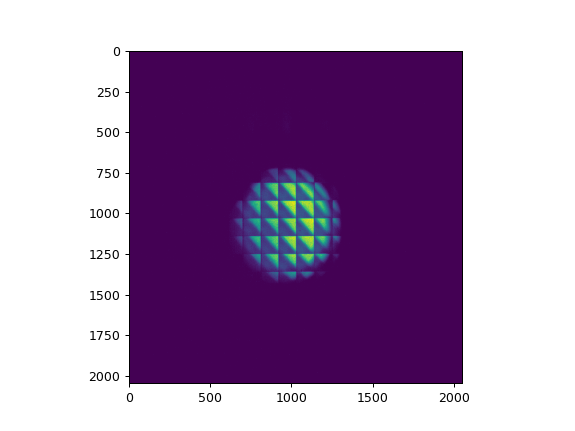

In [3]:
h5f = h5py.File('one_frame.h5','r')
data = h5f['image'][:]
path1 = "data/bad_img1.tiff"
path2 = "data/bad_img2.tiff"
path3 = "data/bad_img3.tiff"

arr = np.array(Image.open(path1))
arr = np.expand_dims(arr, 0)[0]

#arr = data
%matplotlib notebook
plt.imshow(arr)

In [4]:
def chose_level(cd, end = 3):
    cur_lvl = len(cd)-1
    zoom = 2
    max_interval = []
    min_interval = []
    while cur_lvl != end:
        std_max,  std_min= get_extrememums(cd[cur_lvl], 15)
        mask1 = list(np.where(cd[cur_lvl] > std_max)[0])
        mask2 = list(np.where(cd[cur_lvl] < std_min)[0])
        I = np.asarray(get_interval(mask1 + mask2))
      #  print(I)
        if len(set(I))<8:
            std = np.std(I)
            max_intervals = np.where(I>std)[0]
            big_width = np.mean(I[I>std])
    
            c = []

            for i in range(1,len(max_intervals)):
                c+= [sum(I[max_intervals[i-1]+1:max_intervals[i]])]
            min_width = np.median(c)
            max_interval.append(big_width*zoom)
            min_interval.append(min_width*zoom)
            print(big_width*zoom, min_width*zoom)
        else:
            print("BAD LEVEL")
        plt.plot(cd[cur_lvl])
        plt.scatter(mask1, cd[cur_lvl][mask1], color = 'r')
        plt.scatter(mask2, cd[cur_lvl][mask2], color = 'r')
        plt.show()
        zoom*=2
        cur_lvl-=1
        
    values = []
    max_v = Counter(max_interval).most_common(1)[0]
    min_v = Counter(min_interval).most_common(1)[0]
    
    if min_v[1]==1:
        min_v = np.median(min_interval)
    else:
        min_v = min_v[0]
    if max_v[1]==1:
        max_v = np.median(max_interval)
    else:
        max_v = max_v[0]
    return max_v, min_v
        

In [ ]:
w = pywt.Wavelet('db2')
max_lvl = pywt.dwt_max_level(len(arr), w.dec_len)
coeffs = pywt.wavedec(np.mean(arr,axis = 0), 'db2', level = max_lvl)   
ca, cd = coeffs[0],coeffs[1:]  